In [2]:
# Packages have to go in this order... I don't know why

import numpy as np
import pandas as pd
import xarray as xr
import eofs
from eofs.standard import Eof
import glob



#  you need intake-esm V 2020.11.4 and intake V 0.6.0

# import tensorflow as tf

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing


import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm

import copy
import fsspec
import pop_tools



## Functions

In [17]:
def plot_global_corr(field,lons,lats,title):
    plot_field= field.squeeze()
    lon =lons
    lat= lats

    plt.figure(figsize=(25, 20))
    proj = ccrs.PlateCarree(central_longitude=180)
    ax1 = plt.subplot(1, 1, 1, projection=proj)
    ax1.coastlines('50m')
    clevsRWS=np.arange(-1,1.05,.05) 
    haa = cm.get_cmap("Greys",len(clevsRWS))
    haa = haa(np.linspace(0,1,len(clevsRWS)))
    white=[1,1,1,1]
    haa[:3,:] = white
    #either do this 
    cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
    #or set an ocean nanmask! 
    nanmask = np.zeros_like(plot_field)+1
    plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)
    plt.plot([0-180,360-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.tick_params(labelsize=30) 
    ax1.set_extent([0,359,-85,85], crs=ccrs.PlateCarree())
    # ax1.add_feature(states_provinces, edgecolor='black')
    ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
    plt.title(title,fontsize=30)
    plt.colorbar(shrink=0.45)
    plt.show()
    
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))



def NAO_PCS(files,season_months):
    DS = xr.open_mfdataset(files,combine='by_coords')
    for cnt,mons in enumerate(season_months):
        print('doing: ',mons)

        seasonALL  = DS.sel(time = np.in1d(DS['time.month'], mons))
        #have to roll the dataset. 
        print('... rolling DS...')
        ds_rolled = seasonALL.assign_coords(lon=(seasonALL.lon % 360)).roll(lon=(seasonALL.dims['lon'] // 2),roll_coords=True)
        print('... slicing to region ...')
        season1 = ds_rolled.sel(lat=slice(20,80),lon=slice(270,40))
        print('... Time Mean ...')
        Z500 = np.array(season1.groupby('time.year').mean('time')['Z500'].data)
        print('...creating anomaly...')
        TEMP = Z500-np.expand_dims(np.mean(Z500,axis=0),axis=0) #### CHECK THIS!!!!!!!!
    
        #set up latitudinally weighting 
        lats = season1['lat'].data
        lons = season1['lon'].data
        coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
        wgts = np.sqrt(coslat)[..., np.newaxis]
        wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
        wgts = np.expand_dims(wgts,axis=0)
        ##


        print('...Decomposing Modes...')
        solver = Eof(TEMP, weights=wgts)
        eof = solver.eofsAsCorrelation(neofs=3)
        pcs = solver.pcs(npcs = 2,)    
    
        print('...loading daily...')
        dailyZ500 = np.array(season1.Z500.data)
        dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
        pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
        pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

    
        #check to make sure it's the correct direction of magnitude.

        la1 = np.argmin(np.abs(50-lats))
        la2 = np.argmin(np.abs(80-lats))
        print('sum eof NAO:',np.sum(eof[0,la1:la2,:]))
        if np.sum(eof[0,la1:la2,:])>0:
            print('flipping PNA',mons)
            pseudo_pcs[:,0]=-1*pseudo_pcs[:,0]
        
        print('..loading global...')
        globalZ500 = np.array(seasonALL.Z500.data)
        globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

        eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
        eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

        print('correlating')
        for lala in range(globalZ500.shape[1]):
            for lolo in range(globalZ500.shape[2]):
                eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
    
        #plotting
        mon_string = listToString(list(map(str, mons)))
        plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data,'NAO months:'+mon_string)
    
    
        if cnt==0:
            #turn psuedo pcs in to xarray ds 
            DS_indices = xr.Dataset(
            {
                "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
            },
            coords={
            "time": season1.time.data,
            },
            )
        else:
            TempDS = xr.Dataset(
            {
                "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
            },
            coords={
                "time": season1.time.data,
            },
            )
            DS_indices=xr.merge([DS_indices,TempDS])
    return DS_indices


def PNA_NPO_PCS(files,season_months,varnam):
    DS = files
    for cnt,mons in enumerate(season_months):
        print('doing: ',mons)
        
        print('...opening/selecting month!...')
        seasonALL  = DS.sel(time = np.in1d(DS['time.month'], mons))
        print('... slicing to region ...')
        season1=seasonALL.sel(lat=slice(20,85),lon=slice(120,240))
        print('... Time Mean ...')
        Z500 = np.array(season1.groupby('time.year').mean('time')[varnam].data)
        print('...creating anomaly...')
        TEMP = Z500-np.expand_dims(np.mean(Z500,axis=0),axis=0)  #### CHECK THIS!!!!!!!!#### CHECK THIS!!!!!!!!

        #set up weights 
        lats = season1['lat'].data
        lons = season1['lon'].data
        coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
        wgts = np.sqrt(coslat)[..., np.newaxis]
        wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
        wgts = np.expand_dims(wgts,axis=0)
        ##

        print('...Decomposing Modes...')
        solver = Eof(TEMP, weights=wgts)
        eof = solver.eofsAsCorrelation(neofs=3)
        pcs = solver.pcs(npcs = 2,)    
        
        print('...loading daily...')
        dailyZ500 = np.array(season1.TAS.data)
        dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
        pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
        pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

    
        #check to make sure it's the correct direction of magnitude.
        lo1 = np.argmin(np.abs(150-lons))
        lo2 = np.argmin(np.abs(210-lons))
        la1 = np.argmin(np.abs(30-lats))
        la2 = np.argmin(np.abs(55-lats))
        print('sum eof PNA:',np.sum(eof[0,la1:la2,lo1:lo2]))
        if np.sum(eof[0,la1:la2,lo1:lo2])>0:
            print('flipping PNA',mons)
            pseudo_pcs[:,0]=-1*pseudo_pcs[:,0]
        
        
        lo1 = np.argmin(np.abs(140-lons))
        lo2 = np.argmin(np.abs(220-lons))
        la1 = np.argmin(np.abs(25-lats))
        la2 = np.argmin(np.abs(50-lats))
        print('sum eof NPO:',np.sum(eof[1,la1:la2,lo1:lo2]))
        if np.sum(eof[1,la1:la2,lo1:lo2])>0:
            print('flipping NPO',mons)
            pseudo_pcs[:,1]=-1*pseudo_pcs[:,1]
    
        print('..loading global...')
        globalZ500 = np.array(seasonALL.TAS.data)
        globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

        eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
        eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

        print('correlating')
        for lala in range(globalZ500.shape[1]):
            for lolo in range(globalZ500.shape[2]):
                eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
                eof_corr2[lala,lolo]=np.corrcoef(pseudo_pcs[:,1],globalZ500[:,lala,lolo])[0,1]
    
        #plotting
#         mon_string = listToString(list(map(str, mons)))
        plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data,'PNA months:+mon_string')
        plot_global_corr(eof_corr2,seasonALL['lon'].data,seasonALL['lat'].data,'NPO months:mon_string')
    
    
        if cnt==0:
            #turn psuedo pcs in to xarray ds 
            DS_indices = xr.Dataset(
            {
                "PNA": (["time"], pseudo_pcs[:,0].squeeze()),
                "NPO": (["time"], pseudo_pcs[:,1].squeeze())
            },
            coords={
                "time": season1.time.data,
            },
            )
        else:
            TempDS = xr.Dataset(
            {
                "PNA": (["time"], pseudo_pcs[:,0].squeeze()),
                "NPO": (["time"], pseudo_pcs[:,1].squeeze())
            },
            coords={
                "time": season1.time.data,
            },
            )
            DS_indices=xr.merge([DS_indices,TempDS])
        
    return DS_indices



def project_eof_modes():
    return 10

In [18]:
verifdata = "CPC" #can be ERA5 or CPC
verif = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/"+verifdata+".tas.zarr/", consolidated=True)

doing:  [12, 1, 2]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: nan
sum eof NPO: nan
..loading global...
correlating


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


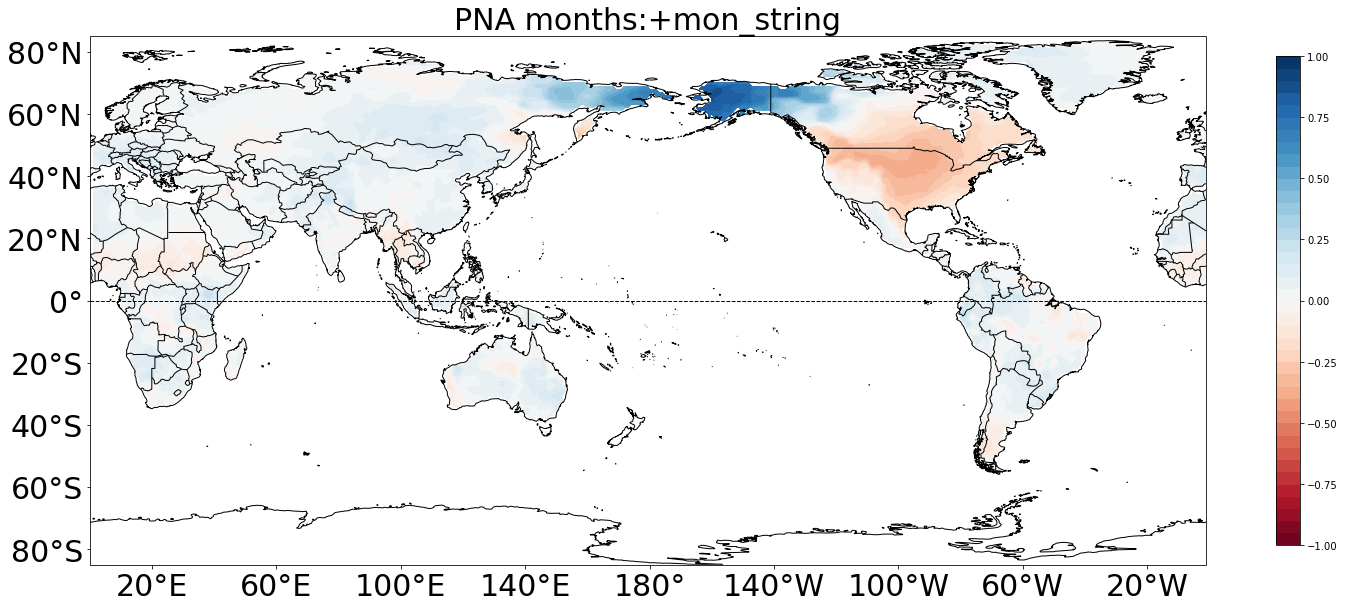

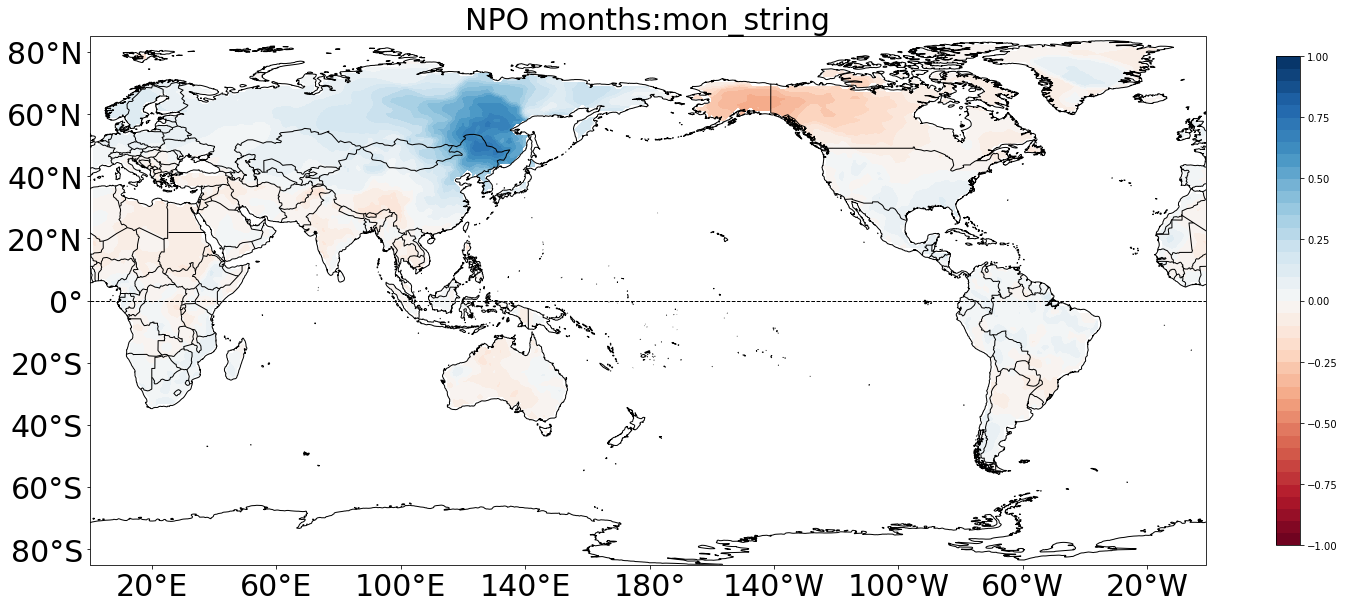

doing:  [3, 4, 5]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: nan
sum eof NPO: nan
..loading global...
correlating


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


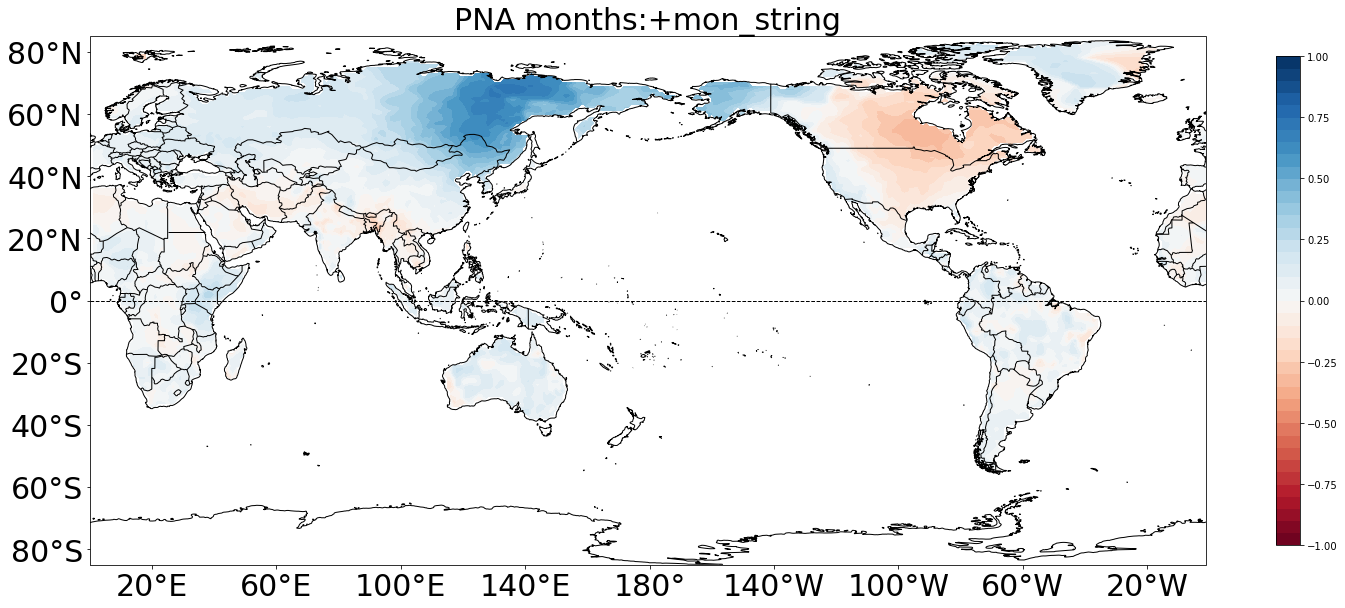

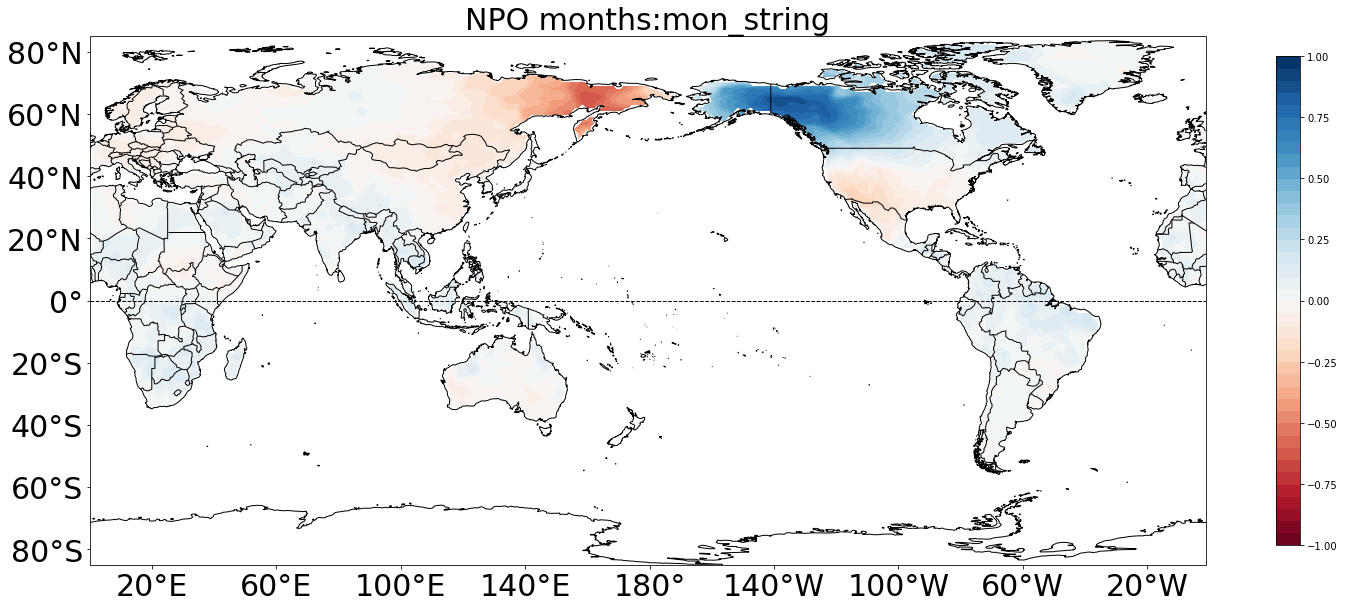

doing:  [6, 7, 8]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: nan
sum eof NPO: nan
..loading global...
correlating


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


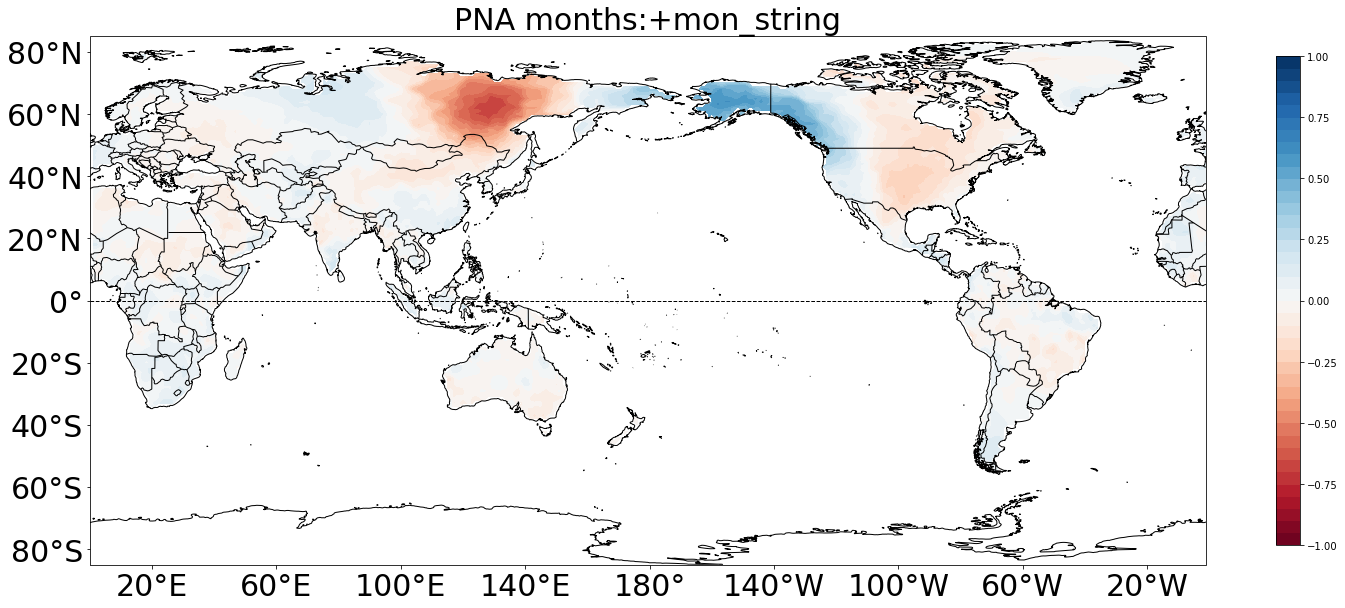

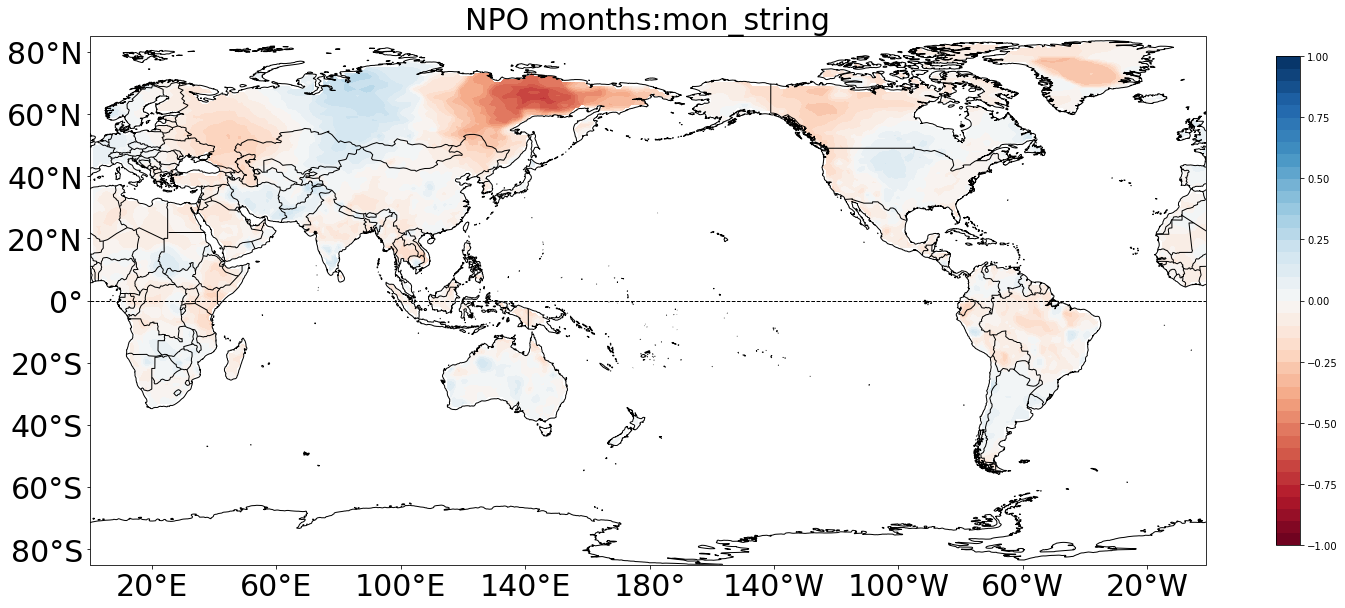

doing:  [9, 10, 11]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: nan
sum eof NPO: nan
..loading global...
correlating


/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/glade/work/wchapman/miniconda3/envs/APSss/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


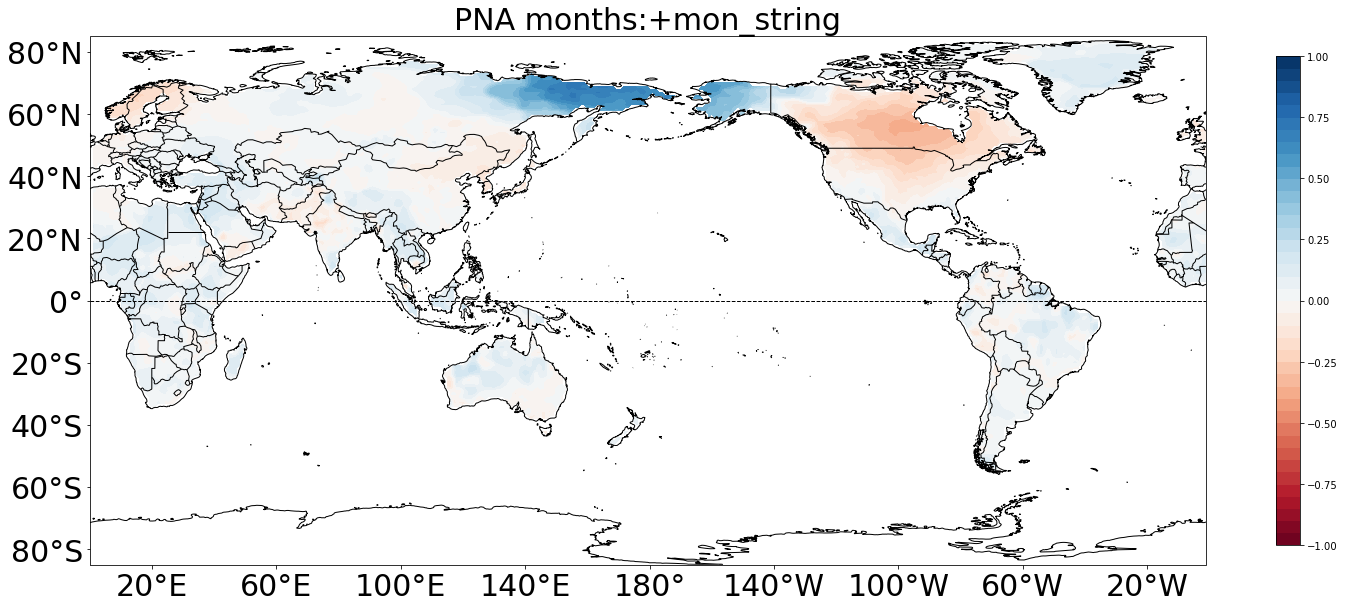

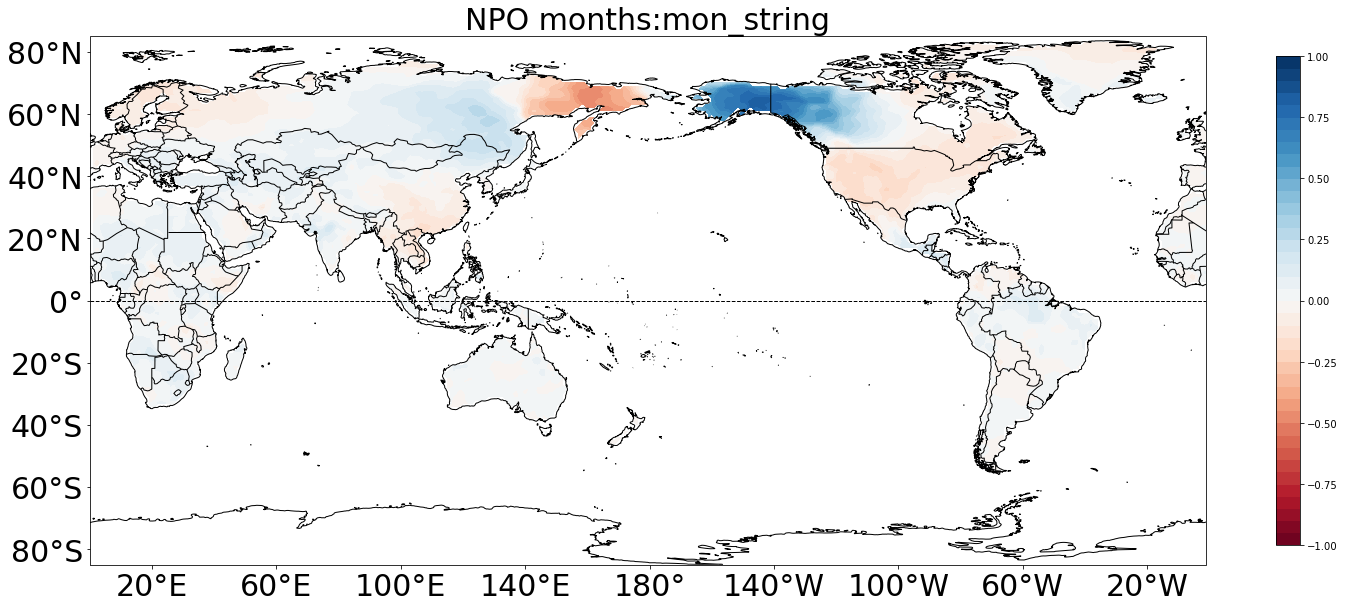

In [29]:
LargeScale_Index = PNA_NPO_PCS(verif,[[12,1,2],[3,4,5],[6,7,8],[9,10,11]],'TAS')

In [30]:
LargeScale_Index

<xarray.Dataset>
Dimensions:  (time: 7670)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2019-12-31
Data variables:
    PNA      (time) float64 -0.291 -0.6139 -0.4205 ... -0.9509 -0.5926 -0.8039
    NPO      (time) float64 -0.05607 -0.3392 -0.3149 ... -0.6369 -0.9395 -1.253

In [40]:
thresh = 1
PNA = np.array(LargeScale_Index.PNA)
indis = np.where(LargeScale_Index['PNA']>thresh)

(array([443., 286., 176., 117.,  56.,  37.,  26.,   8.,   5.,   3.]),
 array([1.00114129, 1.2844992 , 1.5678571 , 1.85121501, 2.13457291,
        2.41793082, 2.70128872, 2.98464663, 3.26800454, 3.55136244,
        3.83472035]),
 <a list of 10 Patch objects>)

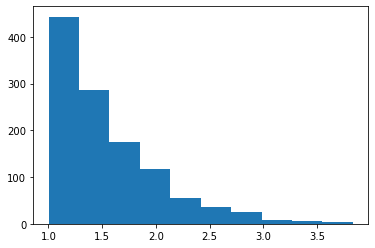

In [41]:
plt.hist(PNA[indis])

In [43]:
verif.sel[indis]

TypeError: 'method' object is not subscriptable

In [48]:
thresh = 1
PNA = np.array(LargeScale_Index.PNA)
indis = np.where(LargeScale_Index['PNA']>thresh)
hindcast_PNA_subset=verif.sel(time=verif.time[indis]).time

In [ ]:
hindcast+

## NAO

doing:  [12, 1, 2]
... rolling DS...
... slicing to region ...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof NAO: -1660.5483939016485
..loading global...
correlating


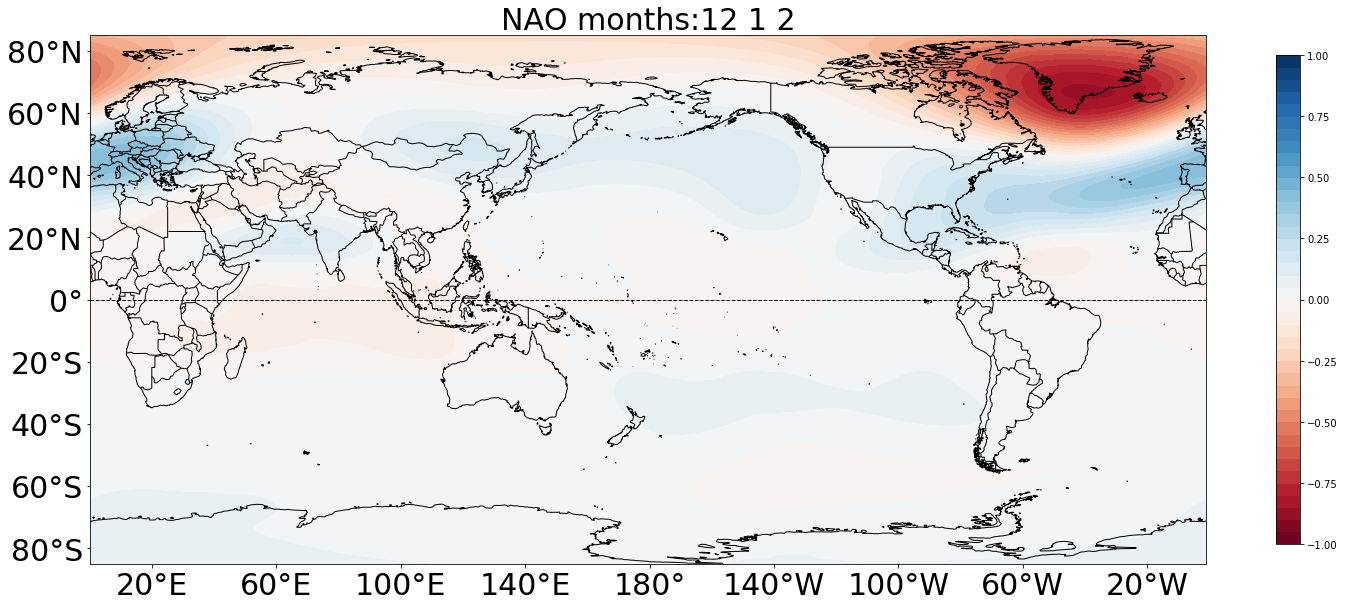

doing:  [3, 4, 5]
... rolling DS...
... slicing to region ...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof NAO: -1238.0588029723099
..loading global...
correlating


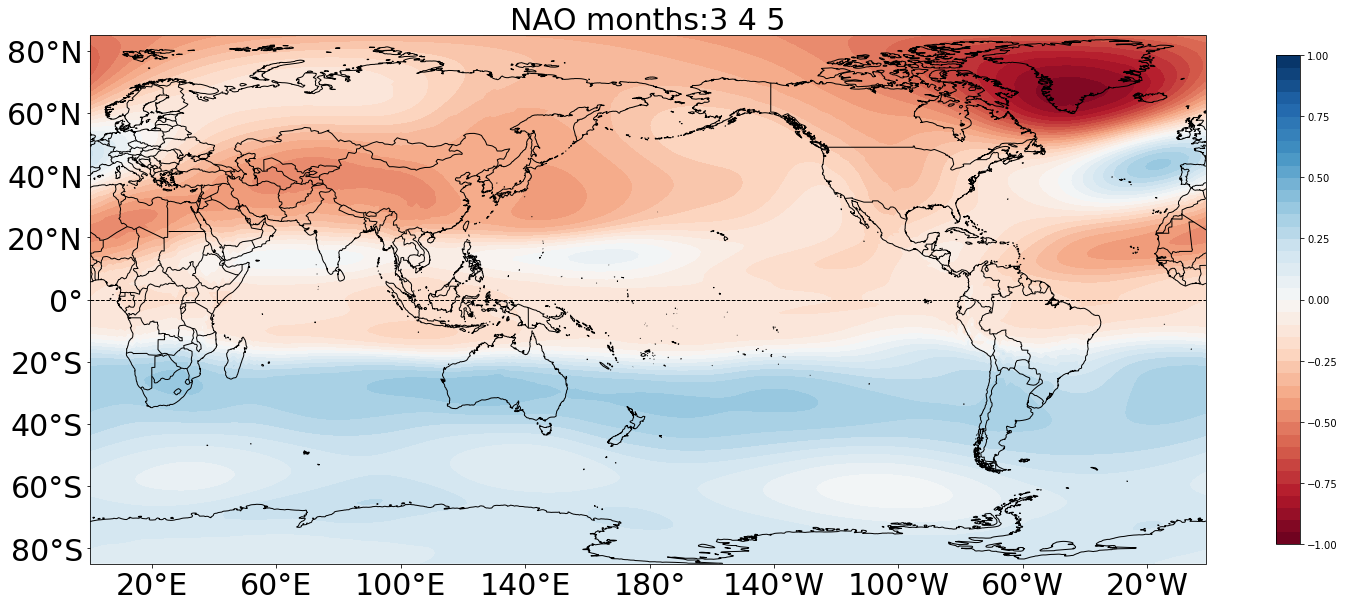

doing:  [6, 7, 8]
... rolling DS...
... slicing to region ...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof NAO: 483.3563447435789
flipping PNA [6, 7, 8]
..loading global...
correlating


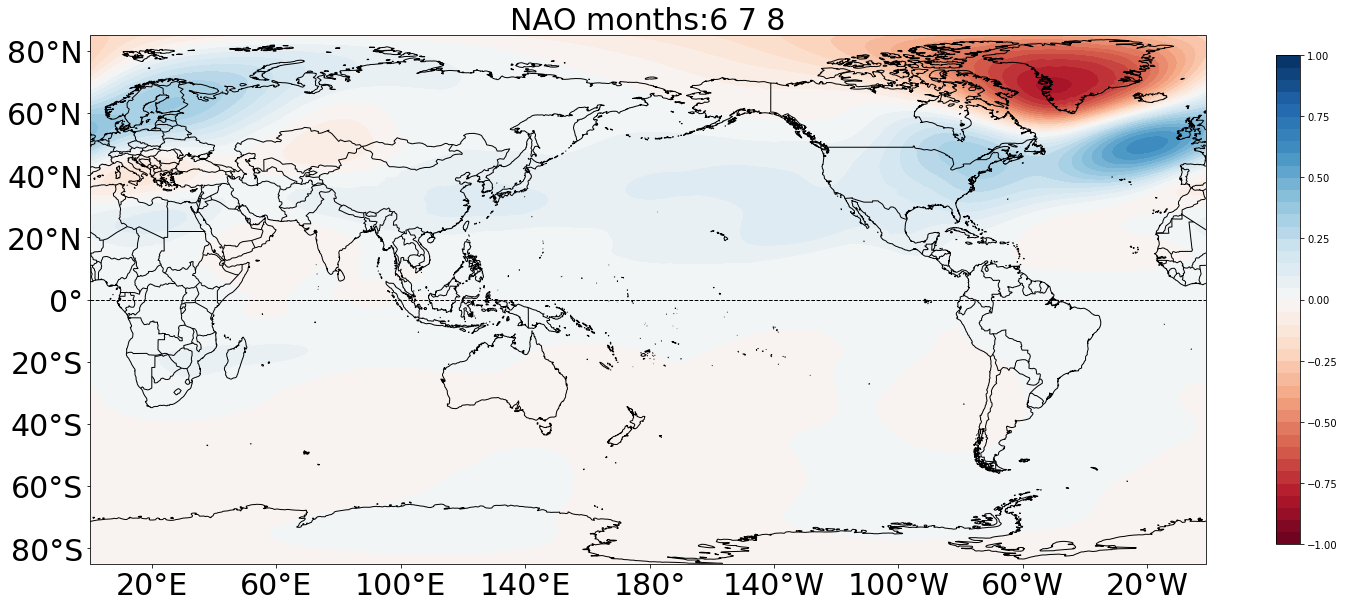

doing:  [9, 10, 11]
... rolling DS...
... slicing to region ...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof NAO: 1060.417714491906
flipping PNA [9, 10, 11]
..loading global...
correlating


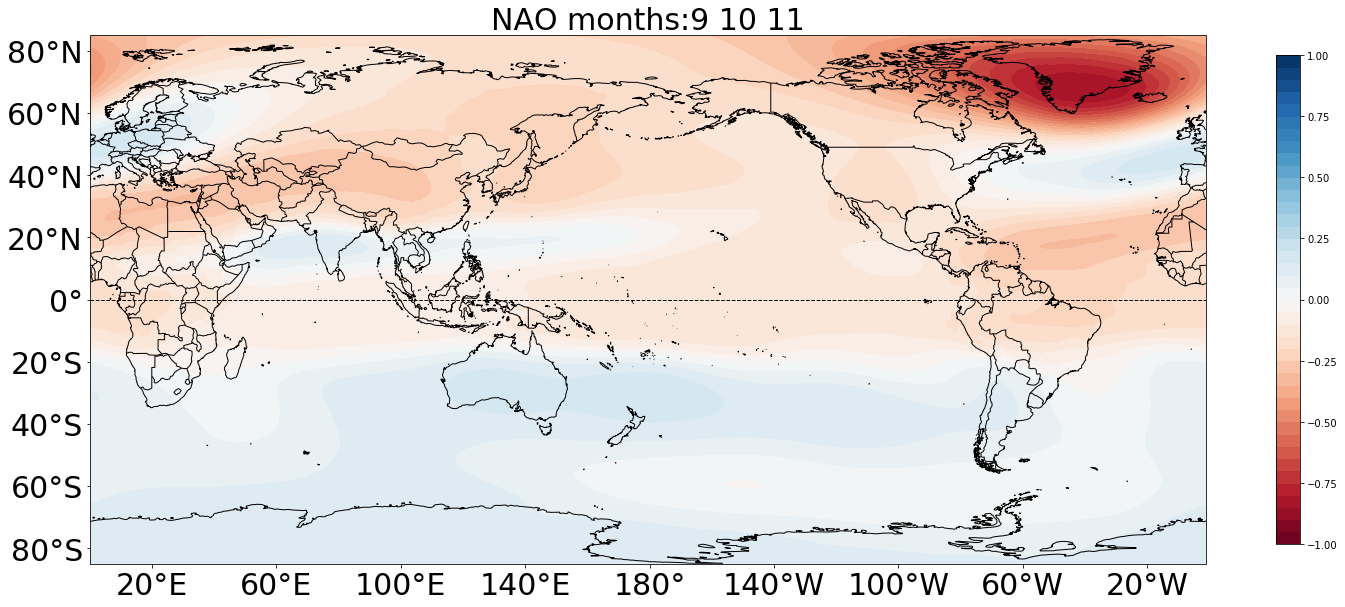

CPU times: user 29min 12s, sys: 3min 35s, total: 32min 48s
Wall time: 31min 33s


In [6]:
%%time
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))
season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
ds_nao = NAO_PCS(files[1:6],season_months)
ds_nao.to_netcdf('/glade/work/wchapman/ASP_summerschool/datasets/NAO_500_1000.nc')

## PNA

doing:  [12, 1, 2]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: 942.4071179819318
flipping PNA [12, 1, 2]
sum eof NPO: 439.13189489331336
flipping NPO [12, 1, 2]
..loading global...
correlating


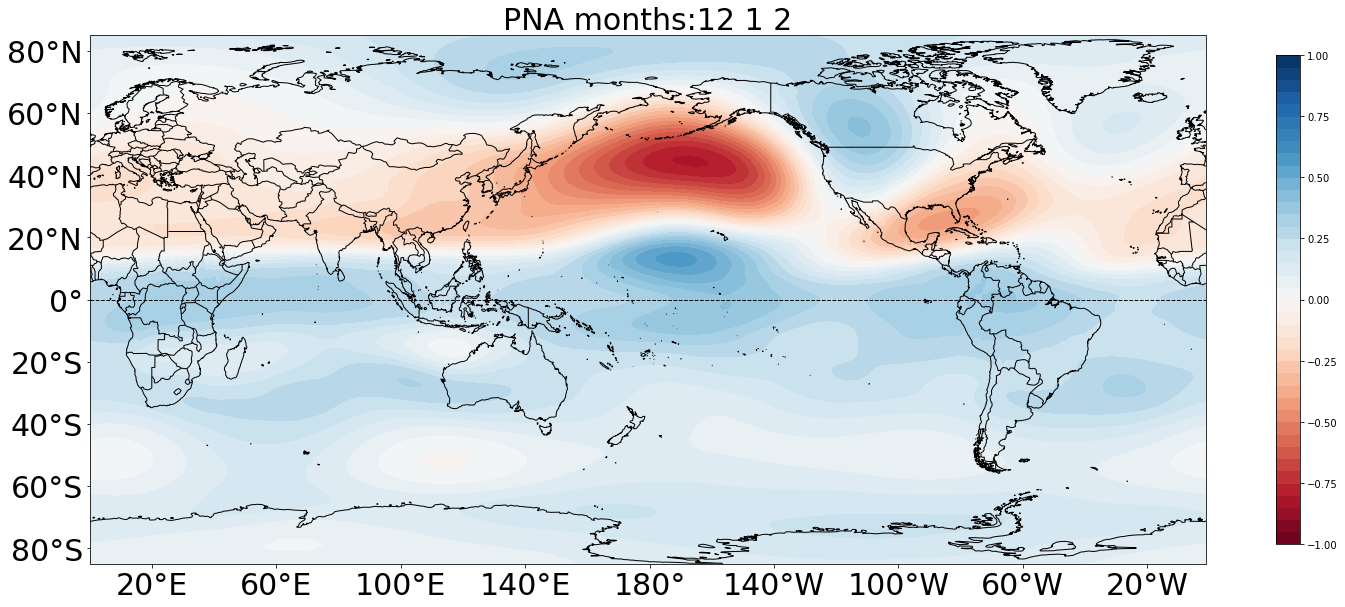

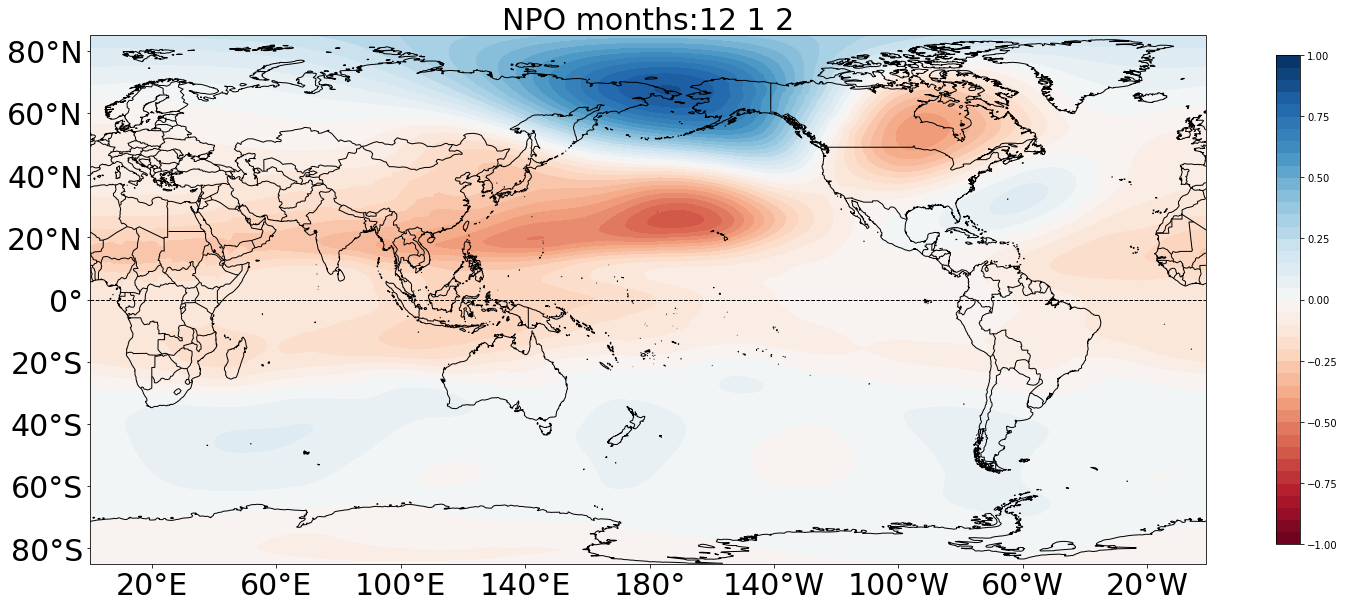

doing:  [3, 4, 5]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: 784.9452560607126
flipping PNA [3, 4, 5]
sum eof NPO: 610.6522247460716
flipping NPO [3, 4, 5]
..loading global...
correlating


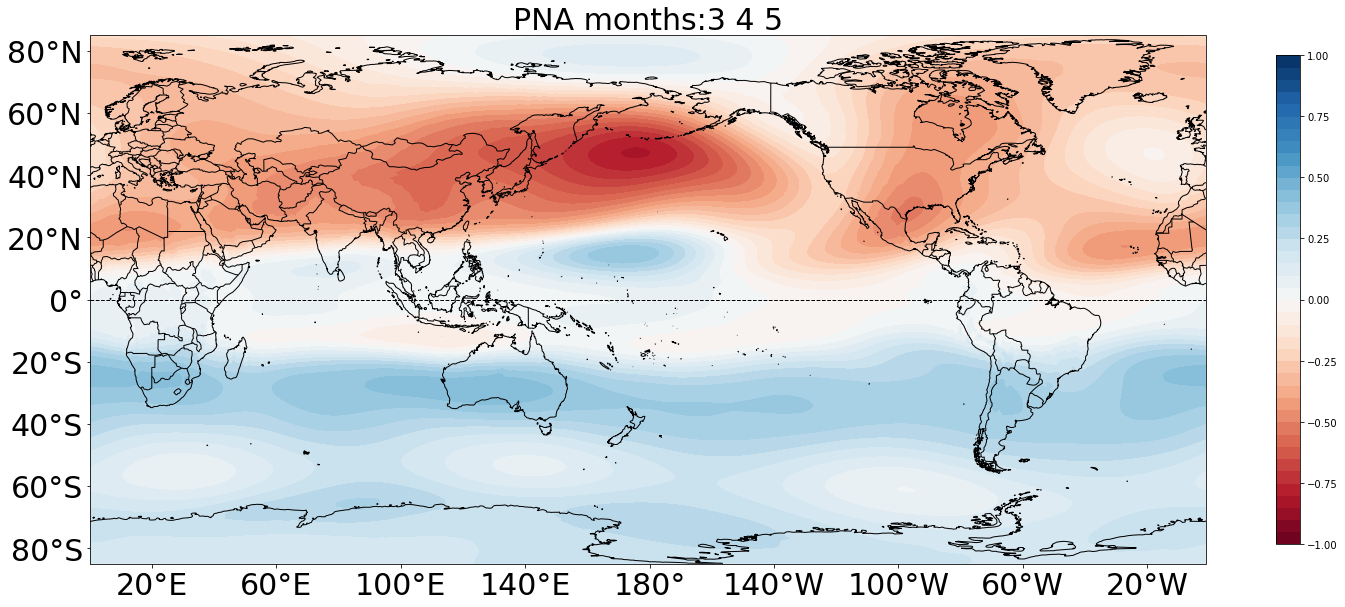

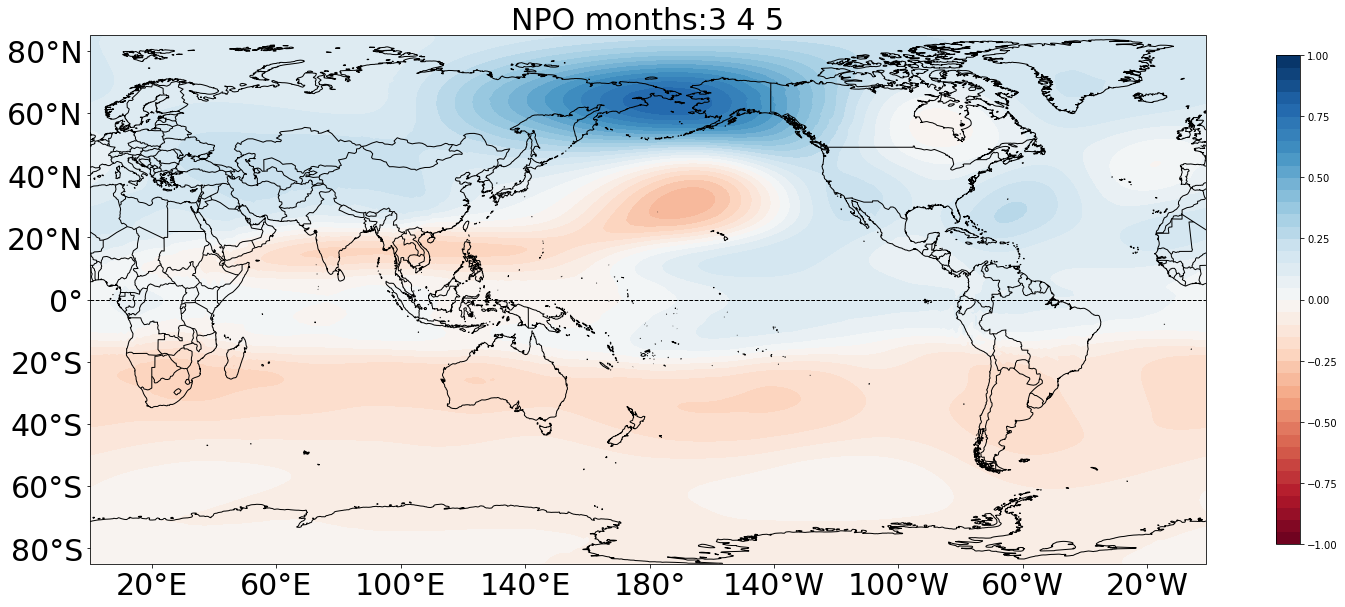

doing:  [6, 7, 8]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: 363.00245036379977
flipping PNA [6, 7, 8]
sum eof NPO: 379.18824225160364
flipping NPO [6, 7, 8]
..loading global...
correlating


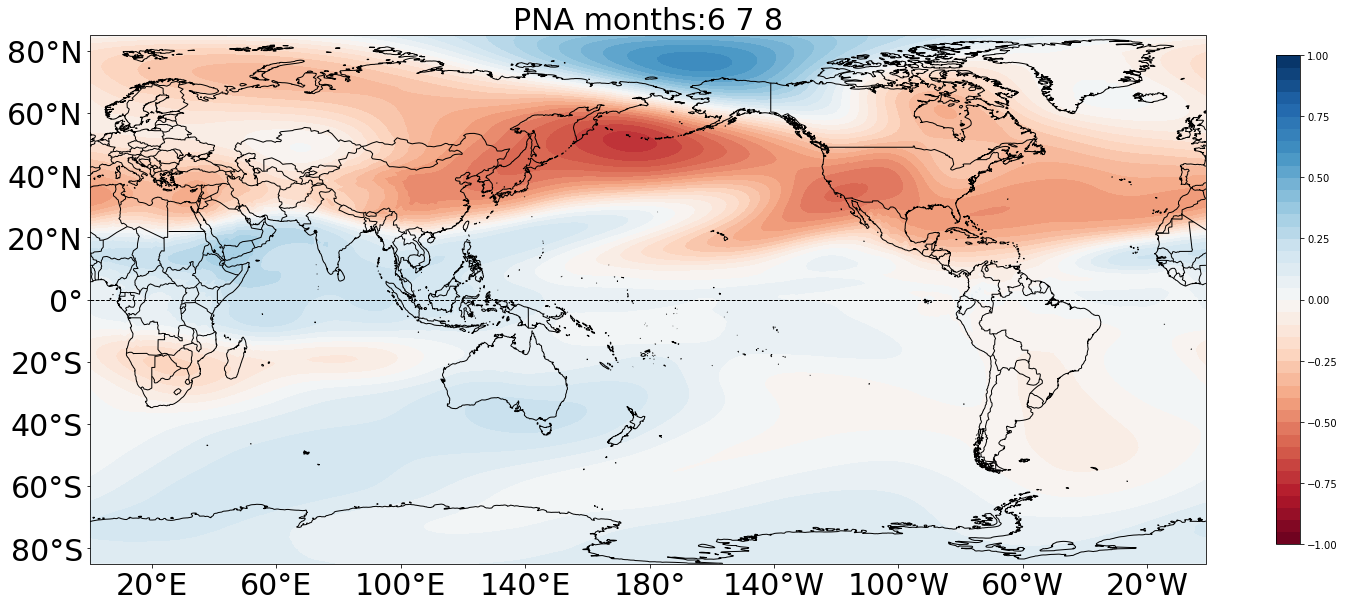

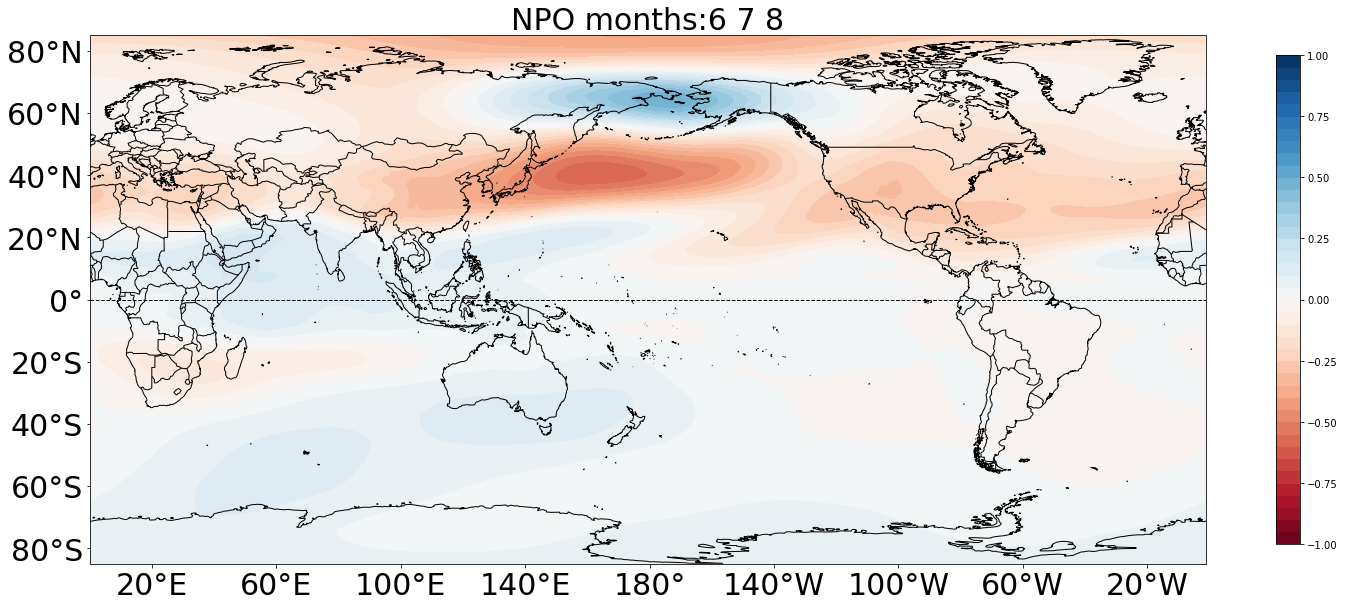

doing:  [9, 10, 11]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: 641.8630327681078
flipping PNA [9, 10, 11]
sum eof NPO: 101.08196768036632
flipping NPO [9, 10, 11]
..loading global...
correlating


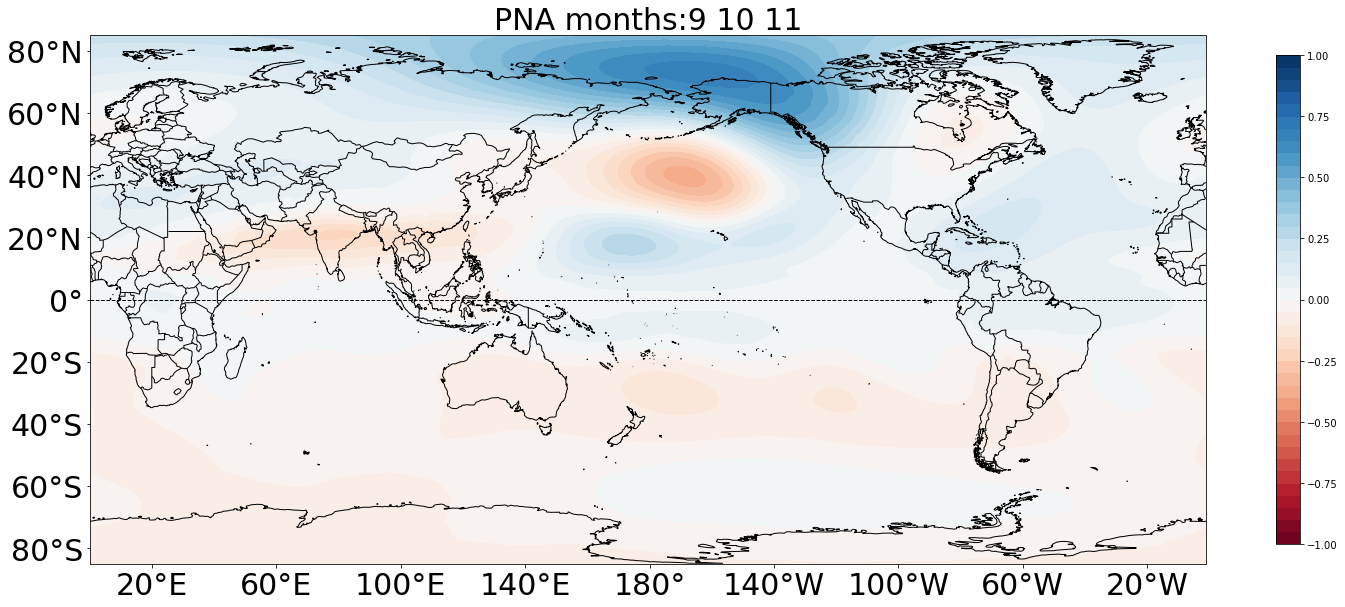

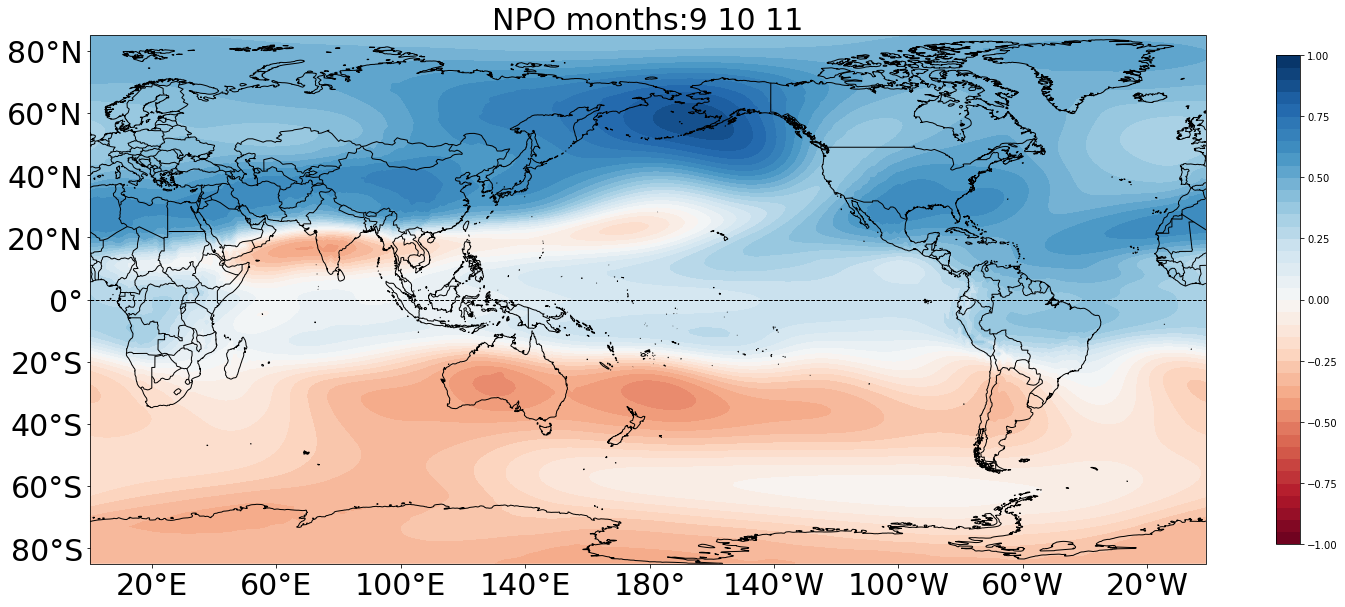

In [5]:
fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
files = sorted(glob.glob(fpath+'*B1850C5CN*'))

season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
ds_pna_npo = PNA_NPO_PCS(files[1:6],season_months)
ds_pna_npo.to_netcdf('/glade/work/wchapman/ASP_summerschool/datasets/PNA_NPO_500_1000.nc')